# Creates plot from DeltaSigma localized using KLLR. 

## Imports

In [2]:
## Use the setup.py file to output directories. 
import sys
sys.path.append('/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/')

from setup import *
toolsdir = tools_dir()
repodir = repo_dir()
chainsdir = chains_dir()
datadir = data_dir()
plotdir = plots_dir()

sys.path.append(toolsdir)
sys.path.append(repodir)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from data_bins import r_cent_lin_norm, r_cent_log_norm
from data_bins import mass_bins, mass_bin_cent
from data_bins import a_bins

In [5]:
with open(datadir + 'MDPL2_DS_R200c_SAGE_Ngal_allM_allz.p', 'rb') as handle:
    matched_halo_df = pickle.load(handle)
matched_halo_df.columns

Index(['id', 'Xoff', 'scale', 'CtreesHaloID', 'pid', 'mvir', 'rvir', 'rs', 'x',
       'y', 'z', 'Mmvir_all', 'M200b', 'M200c', 'M500c', 'T/|U|',
       'Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir', 'R200c', 'R500c',
       'redshift', 'Ngal_Dsep_1', 'Ngal_Rvir', 'Ngal_R200c', 'Ngal_R500c',
       'sigma', 'r_range', 'delta_sigma'],
      dtype='object')

## Calling the KLLR Function

In [6]:
import sys
sys.path.append('/global/u1/z/zzhang13')

from mcmc_full_models import *
from kllr.kllr.regression_model import *
from kllr.kllr.regression_plotting import *
from kllr.kllr.calc_cov_KLLR import *

nBootstrap=100

## Test on benchmark
* R200c, on mass bins
* Also need to apply this to the richness

In [59]:
mass_bin_edges = [5e13, 1e15]
mass_bins = [[mass_bin_edges[i],mass_bin_edges[i+1]] for i in range(len(mass_bin_edges)-1)]
a_bins = [1]

In [73]:
kllr_nbins= 10
kernel_type = 'gaussian'
kernel_width = 0.3

In [74]:
mass_bin = mass_bins[0]
mask = (matched_halo_df.M200c >= mass_bin[0]) & (matched_halo_df.M200c < mass_bin[1]) & (matched_halo_df.scale == a_bins[0]) 
cur_df = matched_halo_df[mask]
#print('M{:.2g}-{:.2g}, z={:.2f}, {}'.format(mass_min, mass_max, 1/cur_a_bin-1, len(cur_df)))

### DeltaSigma

In [75]:
DS = np.array(np.vstack(cur_df['delta_sigma']))

In [91]:
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm

##Testing the KLLR algorithm
radii_bin = 2
print(r_cent_lin_norm[radii_bin])
#Residuals as calculated from KLLR
lm  = kllr_model(kernel_type=kernel_type, kernel_width=kernel_width)
xline, yline, intercept, slopes, scatter, skew, kurt = lm.fit(np.log10(cur_df.M200c), DS[:,radii_bin], \
                                                              bins=kllr_nbins, kernel_width=kernel_width, kernel_type=kernel_type, nBootstrap=1) 

dy_kllr = lm.residuals(np.log10(cur_df.M200c),  DS[:,radii_bin], bins=kllr_nbins, nBootstrap = 1,
                      fast_calc = False, verbose = False, kernel_type=kernel_type, kernel_width=kernel_width)

#Residuals from global mean
profile = DS[:,radii_bin]
profile_mean = np.mean(DS[:,radii_bin])
profile_stddev= np.std(DS[:,radii_bin])
dy_global = profile-profile_mean

0.1778279410038923


In [92]:
##Todo: Make this plot tomorrow morning. 

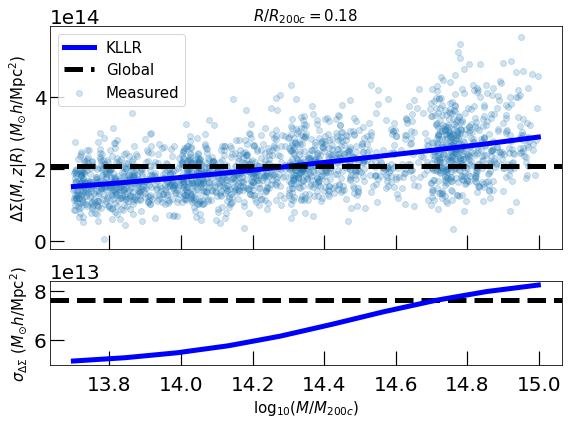

In [96]:
fontsize=15
fig, (a0,a1) = plt.subplots(2, 1, figsize=(8,6), tight_layout=True, sharex=True, gridspec_kw=dict(height_ratios=[4,1.5]))

a0.plot(xline, yline, label='KLLR', color='blue', linewidth=5)
a0.axhline(profile_mean, linewidth=5, linestyle='--', color='black', label='Global')
a0.scatter(np.log10(cur_df.M200c), DS[:,radii_bin], alpha=0.2, label='Measured')
a0.set_title(r'$R/R_{200c}=$'+'{:.2g}'.format(r_cent_lin_norm[radii_bin]), fontsize=fontsize)

a0.set_ylabel(r'$\Delta\Sigma(M,z|R)$ ($M_{\odot}h$/Mpc$^2$)', fontsize=fontsize)
a0.legend(fontsize=fontsize)
#a0.xticks([13.7,14,14.5,15], label=[13.5,14,14.5,15])


a1.axhline(profile_stddev, linestyle='--', color='black', label='Global', linewidth=5)
a1.plot(xline, scatter, label='KLLR', color='blue', linewidth=5)
a1.set_ylabel(r'$\sigma_{\Delta\Sigma}$ ($M_{\odot}h$/Mpc$^2$)', fontsize=fontsize)
a1.set_xlabel(r'$\log_{10}(M/M_{200c})$', fontsize=fontsize)

filename ='mean_DS_KLLR_'+'{:.2g}'.format(r_cent_lin_norm[radii_bin])+'.pdf'
plt.savefig(plotdir+filename)
plt.show()

In [79]:
## Create a subplot showing the reduction in scatter from using KLLR.


## Run on richness

In [149]:
richness = np.array(cur_df['Ngal_R200c'])
print(len(richness))
print(len(cur_df.M200c))
print(richness)

2000
2000
[143. 139. 135. ... 153. 239. 211.]


In [150]:
kllr_nbins= 20
kernel_type = 'gaussian'
kernel_width = 0.1

In [153]:
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm

##Testing the KLLR algorithm
#Residuals as calculated from KLLR
lm  = kllr_model(kernel_type=kernel_type, kernel_width=kernel_width)
xline, yline, intercept, slopes, scatter, skew, kurt = lm.fit(np.log10(cur_df.M200c), np.log10(richness), \
                                                              bins=kllr_nbins, kernel_width=kernel_width, kernel_type=kernel_type, nBootstrap=1) 

dy_kllr = lm.residuals(np.log10(cur_df.M200c), np.log10(richness), bins=kllr_nbins, \
                      fast_calc = False, verbose = False, kernel_type=kernel_type, kernel_width=kernel_width, nBootstrap = 1)

#Residuals from global mean
profile = np.log10(richness)
profile_mean = np.mean(np.log10(richness))
dy_global = profile-profile_mean

[-0.03174171  0.12256999  0.02998291 ... -0.06315742  0.15321247
  0.08370232]
(2000,)
[13.6991871  13.76755909 13.83593108 13.90430308 13.97267507 14.04104707
 14.10941906 14.17779105 14.24616305 14.31453504 14.38290703 14.45127903
 14.51965102 14.58802302 14.65639501 14.724767   14.793139   14.86151099
 14.92988298 14.99825498]


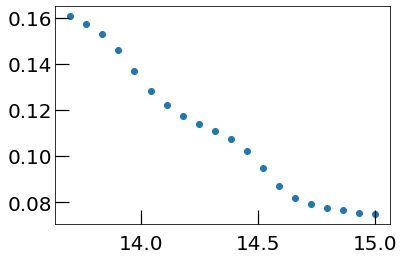

In [164]:
print(dy_kllr)
print(np.shape(dy_kllr))
print(xline)

#Interpolate the error at x_line

plt.scatter(xline, scatter)
plt.show()

## To do: 

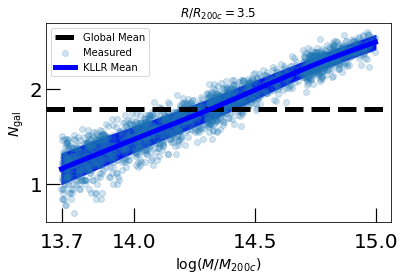

In [169]:
fontsize=14
plt.errorbar(xline, yline, label='KLLR Mean', color='blue', linewidth=5)
plt.fill_between(xline, yline+scatter, yline-scatter, alpha=1, color='blue')
plt.axhline(profile_mean, linewidth=5, linestyle='--', color='black', label='Global Mean')
plt.scatter(np.log10(cur_df.M200c), np.log10(richness), alpha=0.2, label='Measured')
plt.title(r'$R/R_{200c}=$'+'{:.2g}'.format(r_cent_lin_norm[radii_bin]))
plt.xlabel(r'$\log(M/M_{200c})$', fontsize=fontsize)
plt.ylabel(r'$N_{\rm gal}$', fontsize=fontsize)
plt.legend()

plt.tight_layout()
plt.xticks([13.7,14,14.5,15], label=[13.5,14,14.5,15])
filename ='mean_Ngal_R200c_KLLR_'+'{:.2g}'.format(r_cent_lin_norm[radii_bin])+'.pdf'
#plt.savefig(plotdir+filename)
plt.show()